In [1]:
%load_ext autoreload
%autoreload 2

import os
os.chdir(globals()['_dh'][0])
os.chdir('..')
# print(os.path.abspath(os.curdir))

In [2]:
from src.torchwavenet import Wave
from src.torchdataset import RFMixtureDatasetBase
from omegaconf import OmegaConf
import torch
from torch.utils.data import DataLoader
import numpy as np

from torchsummary import summary
import  matplotlib.pyplot as plt
from scipy.stats import binned_statistic

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device: ", device)

Using device:  cuda


In [4]:
soi_type = "QPSK"
interference_type = "CommSignal2"
dataset = RFMixtureDatasetBase(
    root_dir=f"npydataset/Dataset_{soi_type}_{interference_type}_Mixture")
loader = DataLoader(dataset, batch_size=1, shuffle=True)

In [5]:
batch = next(iter(loader))
batch["sample_mix"].shape, batch["sample_soi"].shape, batch["sample_metadata"].shape

(torch.Size([1, 2, 40960]), torch.Size([1, 2, 40960]), torch.Size([1, 2]))

In [6]:
cfg = OmegaConf.load("src/configs/wavenet.yml")
model = Wave(cfg.model).to(device)
summary(model, input_size=batch["sample_mix"].shape[1:])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1           [-1, 128, 40960]             384
            Conv1d-2           [-1, 256, 40960]          98,560
            Conv1d-3           [-1, 256, 40960]          33,024
     ResidualBlock-4  [[-1, 128, 40960], [-1, 128, 40960]]               0
            Conv1d-5           [-1, 256, 40960]          98,560
            Conv1d-6           [-1, 256, 40960]          33,024
     ResidualBlock-7  [[-1, 128, 40960], [-1, 128, 40960]]               0
            Conv1d-8           [-1, 256, 40960]          98,560
            Conv1d-9           [-1, 256, 40960]          33,024
    ResidualBlock-10  [[-1, 128, 40960], [-1, 128, 40960]]               0
           Conv1d-11           [-1, 256, 40960]          98,560
           Conv1d-12           [-1, 256, 40960]          33,024
    ResidualBlock-13  [[-1, 128, 40960], [-1, 128, 40960]]            

In [7]:
# load weights
loaded_model = torch.load(
    "torchmodels/dataset_qpsk_commsignal2_mixture_wavenet/weights-206000.pt")
# loaded_model = torch.load("torchmodels/dataset_qpsk_commsignal2_mixture_wavenet/weights.pt")
print(loaded_model.keys())
model.load_state_dict(loaded_model["model"])

dict_keys(['step', 'model', 'optimizer', 'cfg', 'scaler'])


<All keys matched successfully>

In [8]:
model.eval()

sinr_all = []
soi_target = []
soi_no_mitigation = []
soi_est = []

for i, batch in enumerate(loader):
    # if i == 3:
    #     break
    sample_mix = batch["sample_mix"].to(device)

    sample_soi_hat = model(sample_mix)

    soi_target.extend(batch["sample_soi"].numpy())
    sinr_all.extend(batch["sample_metadata"].numpy())
    soi_no_mitigation.extend(sample_mix.cpu().detach().numpy())
    soi_est.extend(sample_soi_hat.cpu().detach().numpy())

soi_target = np.array(soi_target)
sinr_all = np.array(sinr_all)
soi_no_mitigation = np.array(soi_no_mitigation)
soi_est = np.array(soi_est)
soi_target.shape, sinr_all.shape, soi_no_mitigation.shape, soi_est.shape

((1000, 2, 40960), (1000, 2), (1000, 2, 40960), (1000, 2, 40960))

In [9]:
import rfcutils

2024-03-30 20:18:47.951043: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-30 20:18:47.951106: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-30 20:18:47.952051: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-30 20:18:47.957220: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-30 20:18:49.646599: I tensorflow/core/common_

In [10]:
# we have a stacked tensor along the second axis for the real and imaginary parts
soi_no_mitigation = soi_no_mitigation[:,
                                      0, :] + 1j * soi_no_mitigation[:, 1, :]
soi_target = soi_target[:, 0, :] + 1j * soi_target[:, 1, :]
soi_est = soi_est[:, 0, :] + 1j * soi_est[:, 1, :]
print(soi_target.shape, soi_no_mitigation.shape, soi_est.shape)
bit_demod, _ = rfcutils.qpsk_matched_filter_demod(soi_target)
bit_no_mitigation, _ = rfcutils.qpsk_matched_filter_demod(soi_no_mitigation)
bit_est, _ = rfcutils.qpsk_matched_filter_demod(soi_est)

(1000, 40960) (1000, 40960) (1000, 40960)


2024-03-30 20:18:50.221811: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-03-30 20:18:50.680009: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2024-03-30 20:18:50.742661: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


In [11]:
get_db = lambda p: 10*np.log10(p)
get_pow = lambda s: np.mean(np.abs(s)**2, axis=-1)
get_sinr = lambda s, i: get_pow(s)/get_pow(i)
get_sinr_db = lambda s, i: get_db(get_sinr(s,i))

In [12]:
# evaluate the mse
mse_no_mitigation = get_db(np.mean(np.abs(bit_demod - bit_no_mitigation)**2, axis=-1))
mse_wavenet = get_db(np.mean(np.abs(bit_demod - bit_est)**2, axis=-1))


/tmp/ipykernel_41754/3838547670.py:1: RuntimeWarning: divide by zero encountered in log10
  get_db = lambda p: 10*np.log10(p)


In [13]:
# evaluate the bit error rate
ber_no_mitigation = np.mean(
    bit_no_mitigation != bit_demod, axis=-1).astype(np.float32)
ber_wavenet = np.mean(
    bit_est != bit_demod, axis=-1).astype(np.float32)
print(f"{'Examples':<10} {'BER (No Mitigation)':<20} {'BER (WaveNet)':<20} {'SINR':<10}")
count = 0
for i, (ber1, ber2) in enumerate(zip(ber_no_mitigation, ber_wavenet)):
    if ber1 <= 1e-2 or ber2 <= 1e-2:  # only print if the BER is significant
        print(f"{i + 1:<10} {ber1:<20.10f} {ber2:<20.10f} {sinr_all[i][1]:<10.2f}")
        count += 1
        if count == 30:
            break

Examples   BER (No Mitigation)  BER (WaveNet)        SINR      
1          0.1490234435         0.0000000000         -11.14    
2          0.0000000000         0.0000000000         1.32      
3          0.0845703110         0.0000000000         -7.79     
4          0.0992187485         0.0000000000         -8.54     
5          0.2986328006         0.0000000000         -19.52    
7          0.0001953125         0.0000000000         -0.33     
8          0.2058593780         0.0000000000         -14.71    
10         0.1380859315         0.0000000000         -10.52    
11         0.0000000000         0.0000000000         1.92      
12         0.0515624993         0.0000000000         -5.25     
13         0.3421874940         0.0046875002         -23.21    
15         0.0000000000         0.0000000000         0.34      
16         0.1501953155         0.0000000000         -11.90    
18         0.1041015610         0.0000000000         -8.13     
19         0.0380859375         0.000000

In [14]:
def get_smoothed(sinr, ber, npoints=50):
    bins = np.linspace(sinr.min(), sinr.max(), npoints)
    bin_means, bin_edges, _ = binned_statistic(sinr, ber, statistic='mean', bins=bins)
    
    # To plot the line at the center of the bins, calculate the bin centers
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    return bin_centers, bin_means


Text(0, 0.5, 'BER')

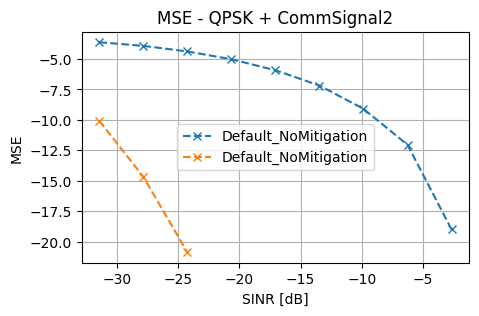

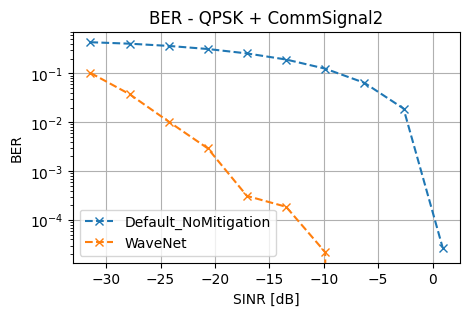

In [16]:
plt.figure(figsize=(5, 3))
plt.plot(*get_smoothed(sinr_all[:, 1], mse_no_mitigation, 11), "x--", label="Default_NoMitigation")
plt.plot(*get_smoothed(sinr_all[:, 1], mse_wavenet, 11), "x--", label="Default_NoMitigation")
plt.grid()
plt.legend()
plt.title(f"MSE - {soi_type} + {interference_type}")
plt.xlabel("SINR [dB]")
plt.ylabel("MSE")

plt.figure(figsize=(5, 3))
plt.semilogy(*get_smoothed(sinr_all[:, 1], ber_no_mitigation, 11), "x--", label="Default_NoMitigation")
plt.semilogy(*get_smoothed(sinr_all[:, 1], ber_wavenet, 11), "x--", label="WaveNet")

plt.grid()
plt.legend()
plt.title(f"BER - {soi_type} + {interference_type}")
plt.xlabel("SINR [dB]")
plt.ylabel("BER")